## Calculation

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_classify_replies')
    return filename[start:end]

def color_rows_by_model(df):
    """Apply color coding to rows based on the values in the 'folder_path' column."""
    def row_color(row):
        if 'GPT35T' in row['folder_path']:
            return ['background-color: #ffebee'] * len(row)  # Light red
        elif 'MIXTRAL' in row['folder_path']:
            return ['background-color: #e8f5e9'] * len(row)  # Light green
        elif 'LLAMA3' in row['folder_path']:
            return ['background-color: #e3f2fd'] * len(row)  # Light blue
        else:
            return [''] * len(row)
    
    return df.style.apply(row_color, axis=1)

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

                # Calculate metrics only for the valid, common rows
                df_pred_clean = df_pred_clean.loc[common_index]
                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Record used and not used row indices
                rows_used = common_index.tolist()
                rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

                metrics['rows_used'] = rows_used
                metrics['rows_not_used'] = rows_not_used
                metrics['rows_not_used_due_to_file'] = rows_not_used_due_to_file

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # # Plot and save the bar chart for each model
    # for model, invalid_rows in invalid_rows_by_model.items():
    #     plt.figure(figsize=(10, 6))
    #     plt.bar([model], [len(invalid_rows)], color='blue', alpha=0.7)
    #     plt.title(f'Total Rows Not Used by {model}')
    #     plt.ylabel('Count of Rows Not Used')
    #     plt.savefig(f'Evaluation_Plots/{model}_rows_not_used_with_GPT35T.pdf')
    #     plt.close()

    # Plot and save a combined bar chart for rows not used by each model
    plt.figure(figsize=(10, 6))
    models = ['LLAMA3', 'GPT35T', 'MIXTRAL']
    counts = [len(invalid_rows_by_model[model]) for model in models]
    plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
    
    # Add exact numbers above the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    # Adjust the upper limit of the y-axis to provide more space above the bars
    plt.ylim(0, max(counts) * 1.1)
    
    plt.title('Total rows not used by each model')
    plt.ylabel('Count of Rows Not Used')
    plt.savefig(fig_name)
    #plt.show()
    plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_csv(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [69]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_classify_replies')
    return filename[start:end]

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # After determining the common index, process files again to calculate metrics only for valid rows
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    metrics_df = pd.DataFrame(results)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Plot and save a combined bar chart for rows not used by each model
    plt.figure(figsize=(10, 6))
    models = ['LLAMA3', 'GPT35T', 'MIXTRAL']
    counts = [len(invalid_rows_by_model[model]) for model in models]
    plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
    
    # Add exact numbers above the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    # Adjust the upper limit of the y-axis to provide more space above the bars
    plt.ylim(0, max(counts) * 1.1)
    
    plt.title('Total rows not used by each model')
    plt.ylabel('Count of Rows Not Used')
    plt.savefig(fig_name)
    #plt.show()
    plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_csv(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [70]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_classify_replies')
    return filename[start:end]

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, filename=None):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if filename:
        plt.savefig(filename)
    #plt.show()
    plt.close()

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    # List to store confusion matrix filenames
    cm_filenames = []

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

                # Generate confusion matrix filenames based on file names
                cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
                cm_filenames.append(cm_filename)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # After determining the common index, process files again to calculate metrics and confusion matrices only for valid rows
    cm_counter = 0
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Calculate and plot confusion matrix
                cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
                plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
                cm_counter += 1

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    metrics_df = pd.DataFrame(results)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Filter out models with no invalid rows
    models = []
    counts = []
    for model, invalid_rows in invalid_rows_by_model.items():
        if invalid_rows:  # Only add models with invalid rows
            models.append(model)
            counts.append(len(invalid_rows))
    
    # Plot and save a combined bar chart for rows not used by each model
    if models:  # Check if there are any models to plot
        plt.figure(figsize=(10, 6))
        plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'][:len(models)], alpha=0.7)
        
        # Add exact numbers above the bars
        for i, count in enumerate(counts):
            plt.text(i, count + 5, str(count), ha='center', fontsize=12)
        
        # Adjust the upper limit of the y-axis to provide more space above the bars
        plt.ylim(0, max(counts) * 1.1)
        
        plt.title('Total Rows Not Used by Each Model')
        plt.ylabel('Count of Rows Not Used')
        plt.savefig(fig_name)
        #plt.show()
        plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_csv(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


### With GPT35T

In [71]:
# # # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file_with_gpt35t = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# # output_file = 'used_rows_for_evaluation_wo_GPT35T.csv'
# # fig_name = 'Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'

# # metrics_df_with_gpt35t, summary_stats_with_gpt35t, total_discarded_rows = process_files(ground_truth_file_with_gpt35t, predicted_folders, valid_classes, output_file, fig_name)



# metrics_df_with_gpt35t, summary_stats_with_gpt35t, count_rows_not_used, cm_filenames = process_files(
#     ground_truth_file=r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx',
#     predicted_folders=[
#         r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', 
#         r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', 
#         r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct'
#     ],
#     valid_classes=['appropriate', 'inappropriate', 'offensive', 'violent'],
#     output_file='used_rows_for_evaluation_with_GPT35T.csv',
#     fig_name='Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'
# )



# # Apply color coding to the metrics DataFrame
# styled_metrics_df_with_gpt35t = color_rows_by_model(metrics_df_with_gpt35t)

# # Apply color coding to the metrics DataFrame
# styled_summary_stats_df_with_gpt35t = color_rows_by_model(summary_stats_with_gpt35t)

# # Save the metrics DataFrame as an Excel file
# output_file = 'metrics_results_ALL_FINAL_with_GPT35T.xlsx'
# styled_metrics_df_with_gpt35t.to_excel(output_file, index=False)
# print(f"Metrics saved to {output_file}")

# # Save the summary statistics DataFrame as an Excel file
# summary_output_file_with_gpt35t = 'summary_stats_ALL_FINAL_with_GPT35T.xlsx'
# styled_summary_stats_df_with_gpt35t.to_excel(summary_output_file_with_gpt35t, index=False)
# print(f"Summary statistics saved to {summary_output_file_with_gpt35t}")


### Without GPT35T

## Visualisations

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(30, 15), gridspec_kw={'hspace': 1.5})  # Increased hspace
    
    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=18, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
            # Add a space between "Task" and the number
            formatted_tasks.append(f"$\\bf{{Task\ {i+1}:}}$ {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
        ax.tick_params(axis='x', labelsize=23)
        ax.tick_params(axis='y', labelsize=23)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()


In [73]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#FF6F61'  # Coral
#     elif 'MIXTRAL' in path:
#         return '#6BAED6'  # Medium Blue
#     elif 'LLAMA' in path:
#         return '#74C476'  # Light Green
#     else:
#         return '#ffffff'  # White

# def darker_color(color, factor=0.8):
#     """Darken the color by a given factor."""
#     color_rgb = mcolors.to_rgb(color)
#     return tuple([c * factor for c in color_rgb])

# def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
#     num_tasks = len(summary_stats_df['task'].unique())
#     bar_width = 1.8  # Increase in bar width
#     group_spacing = 0.5  # Less spacing between groups for compactness
    
#     # Increase the figure size to accommodate larger bars and groups
#     fig, axs = plt.subplots(2, 1, figsize=(40, 25), gridspec_kw={'hspace': 1})
    
#     for ax, metric in zip(axs, metrics):
#         x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             color = color_code_for_path(short_path)
#             edge_color = darker_color(color)  # Adjust edge color automatically
            
#             ax.bar(x + i * bar_width, y, 
#                    yerr=yerr, width=bar_width, label=short_path, 
#                    color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5)
            
#             # Place mean and std dev labels above the error bars
#             for j in range(len(y)):
#                 ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
#                         f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
#                         ha='center', fontsize=18, color='black', alpha=0.9)
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
#         # Modify the task names to include line breaks where needed
#         tasks = summary_stats_df['task'].unique()
#         formatted_tasks = [task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript') for task in tasks]

#         # Set the modified tasks as xtick labels
#         ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
#         ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
#         ax.tick_params(axis='x', labelsize=23)
#         ax.tick_params(axis='y', labelsize=23)
        
#         # Adding lighter gridlines
#         ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
#         # Adjust y-limit to provide space at the top
#         ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
#         # Place the legend inside the plot, in the upper left corner
#         ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=18, frameon=False)
    
#     plt.tight_layout(rect=[0, 0, 0.85, 0.95])
#     plt.savefig(name_fig)
#     plt.show()


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Add "Task XY:" to the task names by grouping and transforming
    summary_stats_df['task_with_number'] = summary_stats_df.groupby('task').ngroup() + 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].apply(lambda x: f"$\\bf{{Task {x}:}}$") + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 9), gridspec_kw={'wspace': 0.1})
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with increased legend title size
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                    cbar_kws={'label': f'{metric.capitalize()}', 'fontsize': 20}, ax=ax, annot_kws={"size": 16})
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=20)
        ax.set_xlabel('Model', fontsize=18)
        
        # Only display the task name once
        if metric == 'accuracy':
            ax.set_ylabel('Task', fontsize=16)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
        ax.tick_params(axis='y', labelsize=18)
        
        # Adjust the aspect ratio
        ax.set_aspect(aspect='auto')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()


In [75]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#FF6F61'  # Coral
#     elif 'MIXTRAL' in path:
#         return '#6BAED6'  # Medium Blue
#     elif 'LLAMA' in path:
#         return '#74C476'  # Light Green
#     else:
#         return '#ffffff'  # White

# def darker_color(color, factor=0.8):
#     """Darken the color by a given factor."""
#     color_rgb = mcolors.to_rgb(color)
#     return tuple([c * factor for c in color_rgb])

# def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
#     num_tasks = len(summary_stats_df['task'].unique())
#     bar_width = 1.8  # Increase in bar width
#     group_spacing = 0.5  # Less spacing between groups for compactness
    
#     # Increase the figure size to accommodate larger bars and groups
#     fig, axs = plt.subplots(2, 1, figsize=(40, 25), gridspec_kw={'hspace': 1.5})  # Increased hspace
    
#     for ax, metric in zip(axs, metrics):
#         x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
#         # Extract the first task to set as baseline
#         baseline_task = summary_stats_df['task'].unique()[0]
#         baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
#         # Draw horizontal lines for the baseline task in the background
#         for i, (idx, row) in enumerate(baseline_data.iterrows()):
#             baseline_value = row[f'{metric}_mean']
#             color = color_code_for_path(row['short_path'])
#             ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             color = color_code_for_path(short_path)
#             edge_color = darker_color(color)  # Adjust edge color automatically
            
#             bars = ax.bar(x + i * bar_width, y, 
#                           yerr=yerr, width=bar_width, label=short_path, 
#                           color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
#             # Place mean and std dev labels above the error bars
#             for j in range(len(y)):
#                 ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
#                         f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
#                         ha='center', fontsize=18, color='black', alpha=0.9, zorder=3)
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
#         # Modify the task names to include line breaks where needed and add "Task XY:" in bold
#         tasks = summary_stats_df['task'].unique()
#         formatted_tasks = []
#         for i, task in enumerate(tasks):
#             formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
#             formatted_tasks.append(f"$\\bf{{Task {i+1}:}}$ {formatted_task}")

#         # Set the modified tasks as xtick labels
#         ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
#         ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
#         ax.tick_params(axis='x', labelsize=23)
#         ax.tick_params(axis='y', labelsize=23)
        
#         # Adding lighter gridlines
#         ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
#         # Adjust y-limit to provide space at the top
#         ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
#         # Place the legend in the bottom right corner with a white, slightly transparent background
#         legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
#         legend.get_frame().set_facecolor('white')
#         legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
#     plt.tight_layout(rect=[0, 0, 0.85, 0.95])

#     # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
#     #plt.savefig(f"{name_fig}.png", bbox_inches='tight')
#     plt.savefig(f"{name_fig}", bbox_inches='tight')
    
#     plt.show()


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(22, 18), gridspec_kw={'hspace': 0.4})  # Reduced hspace for smaller space between plots
    
    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=22, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=30)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=28)
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
            # Add a space between "Task" and the number
            formatted_tasks.append(f"$\\bf{{Task\ {i+1}:}}$ {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=0, ha='center', fontsize=16)
        ax.tick_params(axis='x', labelsize=26)
        ax.tick_params(axis='y', labelsize=26)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()

# Example usage:
# analyze_and_plot(metrics_df, summary_stats_df, "combined_metrics_plot")


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(22, 18), gridspec_kw={'hspace': 0.4})  # Reduced hspace for smaller space between plots
    
    # Automatically assign specific task numbers with bold formatting
    task_numbering = {0: "\\bf{Task 1:}", 1: "\\bf{Task 4:}"}  # Automatically assign "Task 1:" and "Task 4:"

    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=22, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=30)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=28)
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
            # Automatically format the task with bold "Task 1:" and "Task 4:"
            task_label = task_numbering.get(i, f"\\bf{{Task {i+1}:}}")
            formatted_tasks.append(f"${task_label}$ {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=0, ha='center', fontsize=16)
        ax.tick_params(axis='x', labelsize=28)
        ax.tick_params(axis='y', labelsize=28)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()

# Example usage:
# analyze_and_plot(metrics_df, summary_stats_df, "combined_metrics_plot")


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Add "Task XY: " to the task names by grouping and transforming
    summary_stats_df['task_with_number'] = summary_stats_df.groupby('task').ngroup() + 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].apply(lambda x: f"$\\bf{{Task\ {x}:}}$") + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    # Create subplots to place both heatmaps in one figure
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjusted figure size to make boxes smaller
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with adjusted text sizes
        heatmap = sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                              cbar_kws={'label': f'{metric.capitalize()}'}, annot_kws={"size": 14}, ax=ax,
                              square=False)  # Set square=True to adjust aspect ratio
        
        # Set the title of the colorbar with increased font size
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.set_ylabel(f'{metric.capitalize()}', fontsize=16)
        
        # Increase the font size of the colorbar tick labels
        colorbar.ax.tick_params(labelsize=12)
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=18)
        ax.set_xlabel('Model', fontsize=14)
        
        # Adjust the y-axis label sizes and set them horizontally
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=16)  # Horizontal y-axis labels
    
    # Adjust the layout to make room for y-axis labels and spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)

    # Increase the left margin to accommodate longer y-axis labels
    plt.subplots_adjust(left=0.25)  # Adjust the value to find the right balance

    plt.savefig(f"{fig_name}", bbox_inches='tight')
    plt.show()

# Example usage:
# analyze_and_plot_heatmap(metrics_df, summary_stats_df, "combined_heatmap")


In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Automatically assign specific task numbers
    task_numbering = {0: "Task 1:", 1: "Task 4:"}  # Automatically assign "Task 1:" and "Task 4:"

    # Create a column with task numbering based on their order
    summary_stats_df['task_with_number'] = summary_stats_df['task'].rank(method='dense').astype(int) - 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].map(task_numbering) + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    # Create subplots to place both heatmaps in one figure
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjusted figure size to make boxes smaller
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with adjusted text sizes
        heatmap = sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                              cbar_kws={'label': f'{metric.capitalize()}'}, annot_kws={"size": 14, "weight": "bold"}, ax=ax,
                              square=False)  # Set square=True to adjust aspect ratio
        
        # Set the title of the colorbar with increased font size
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.set_ylabel(f'{metric.capitalize()}', fontsize=16)
        
        # Increase the font size of the colorbar tick labels
        colorbar.ax.tick_params(labelsize=12)
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=18)
        ax.set_xlabel('Model', fontsize=16)
        
        # Adjust the y-axis label sizes and set them horizontally
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=16, weight='bold')  # Bold y-axis labels
    
    # Adjust the layout to make room for y-axis labels and spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)

    # Increase the left margin to accommodate longer y-axis labels
    plt.subplots_adjust(left=0.25)  # Adjust the value to find the right balance

    plt.savefig(f"{fig_name}", bbox_inches='tight')
    plt.show()

# Example usage:
# analyze_and_plot_heatmap(metrics_df, summary_stats_df, "combined_heatmap")


In [140]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    # Apply mapping and filter out 'none' values
    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    ground_truth_df = ground_truth_df[ground_truth_df['type_reply'] != 'none']  # Remove 'none' values
    
    y_true = ground_truth_df['type_reply'].astype(str)
    initial_row_count = len(y_true)
    
    results = []
    skipped_files = []
    valid_indices_all_models = set(y_true.index)  # Start with all indices being valid

    # Track invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    # List to store confusion matrix filenames
    cm_filenames = []

    # First pass to determine valid indices across all models
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                valid_indices = df_pred.index[
                    df_pred['classification_cleaned'].notna() &
                    df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Update the global set of valid indices
                valid_indices_all_models = valid_indices_all_models.intersection(valid_indices)
                
                # Track invalid rows for this specific file
                invalid_indices = set(df_pred.index) - set(valid_indices)
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)

                # Generate confusion matrix filenames based on file names
                cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
                cm_filenames.append(cm_filename)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Convert valid indices set to list for DataFrame operations
    common_index = list(valid_indices_all_models)
    
    # Recalculate counts of used and not used rows
    count_rows_used_across_all_models = len(common_index)
    count_rows_not_used_across_all_models = initial_row_count - count_rows_used_across_all_models

    # Second pass to calculate metrics and generate confusion matrices only for valid rows
    cm_counter = 0
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Calculate and plot confusion matrix
                cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
                plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
                cm_counter += 1

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Plot and save a combined bar chart for rows not used by each model
    if any(invalid_rows_by_model.values()):  # Check if there are any invalid rows to plot
        plt.figure(figsize=(10, 6))
        models = list(invalid_rows_by_model.keys())
        counts = [len(invalid_rows_by_model[model]) for model in models]
        plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
        
        # Add exact numbers above the bars
        for i, count in enumerate(counts):
            plt.text(i, count + 5, str(count), ha='center', fontsize=16)
        
        # Adjust the upper limit of the y-axis to provide more space above the bars
        plt.ylim(0, max(counts) * 1.1)
        
        plt.title('Total rows not used by each model')
        plt.ylabel('Count of Rows Not Used')
        plt.savefig(fig_name)
        plt.show()
        plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_excel(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "Llama-3"
    elif "GPT35T" in folder_path:
        return "GPT-3.5-Turbo"
    elif "MIXTRAL" in folder_path:
        return "Mixtral"
    return folder_path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Automatically assign specific task numbers
    task_numbering = {0: "Task 1:", 1: "Task 4:"}  # Automatically assign "Task 1:" and "Task 4:"

    # Create a column with task numbering based on their order
    summary_stats_df['task_with_number'] = summary_stats_df['task'].rank(method='dense').astype(int) - 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].map(task_numbering) + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    # Create subplots to place both heatmaps in one figure
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjusted figure size to make boxes smaller
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with adjusted text sizes
        heatmap = sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                              cbar_kws={'label': f'{metric.capitalize()}'}, annot_kws={"size": 14}, ax=ax,
                              square=False)  # Set square=True to adjust aspect ratio
        
        # Set the title of the colorbar with increased font size
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.set_ylabel(f'{metric.capitalize()}', fontsize=16)
        
        # Increase the font size of the colorbar tick labels
        colorbar.ax.tick_params(labelsize=16)
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=16)
        ax.set_xlabel('Model', fontsize=15)
        
        # Adjust the y-axis label sizes and set them horizontally
        ax.set_ylabel('')
        
        # Increase the font size of the x-axis tick labels
        ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label font size
        
        # Manually set y-tick labels with partial bold formatting
        y_labels = []
        for label in ax.get_yticklabels():
            text = label.get_text()
            if 'Task' in text:
                parts = text.split(' ', 1)  # Split into "Task X:" and the rest
                bold_part = r"$\bf{" + parts[0] + "}$"
                normal_part = parts[1] if len(parts) > 1 else ''
                y_labels.append(bold_part + ' ' + normal_part)
            else:
                y_labels.append(text)

        ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=16)
    
    # Adjust the layout to make room for y-axis labels and spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)

    # Increase the left margin to accommodate longer y-axis labels
    plt.subplots_adjust(left=0.25)  # Adjust the value to find the right balance

    plt.savefig(f"{fig_name}", bbox_inches='tight')
    plt.show()


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "Llama-3"
    elif "GPT35T" in folder_path:
        return "GPT-3.5-Turbo"
    elif "MIXTRAL" in folder_path:
        return "Mixtral"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path or 'GPT-3.5-Turbo' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path or 'Mixtral' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path or 'Llama-3' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(22, 18), gridspec_kw={'hspace': 0.4})  # Reduced hspace for smaller space between plots
    
    # Automatically assign specific task numbers with bold "Task" and regular numbers
    task_numbering = {0: "$\\bf{Task\ 1:}$", 1: "$\\bf{Task\ 4:}$"}  # Automatically assign "Task 1:" and "Task 4:"

    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=24, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=30)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=28)
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
            # Automatically format the task with bold "Task " and regular numbers
            task_label = task_numbering.get(i, f"$\\bf{{Task\ {i+1}:}}$")
            formatted_tasks.append(f"{task_label} {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=0, ha='center', fontsize=16)
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=28)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.15)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()

# Example usage:
# analyze_and_plot(metrics_df, summary_stats_df, "combined_metrics_plot")


### With GPT35T

In [66]:
# # List of folders for different models
# predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# ground_truth_file_with_gpt35t = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# output_file = 'used_rows_for_evaluation_wo_GPT35T.csv'
# fig_name = 'Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'

# metrics_df_with_gpt35t, summary_stats_with_gpt35t, total_discarded_rows = process_files(ground_truth_file_with_gpt35t, predicted_folders, valid_classes, output_file, fig_name)



metrics_df_with_gpt35t, summary_stats_with_gpt35t, count_rows_not_used, cm_filenames = process_files(
    ground_truth_file=r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\NEW_IMSyPP_EN_YouTube_comments_evaluation_context_1517_PREPROCESSED.xlsx',
    predicted_folders = [
    r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE', 
    r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE', 
    r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE'
],
    valid_classes=['appropriate', 'inappropriate', 'offensive', 'violent'],
    output_file='used_rows_for_evaluation_with_GPT35T_BASELINE_1517.xlsx',
    fig_name='Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T_BASELINE_1517.pdf'
)



# Apply color coding to the metrics DataFrame
styled_metrics_df_with_gpt35t = color_rows_by_model(metrics_df_with_gpt35t)

# Apply color coding to the metrics DataFrame
styled_summary_stats_df_with_gpt35t = color_rows_by_model(summary_stats_with_gpt35t)

# Save the metrics DataFrame as an Excel file
output_file = 'metrics_results_ALL_FINAL_with_GPT35T_BASELINE_1517.xlsx'
styled_metrics_df_with_gpt35t.to_excel(output_file, index=False)
print(f"Metrics saved to {output_file}")

# Save the summary statistics DataFrame as an Excel file
summary_output_file_with_gpt35t = 'summary_stats_ALL_FINAL_with_GPT35T_BASELINE_1517.xlsx'
styled_summary_stats_df_with_gpt35t.to_excel(summary_output_file_with_gpt35t, index=False)
print(f"Summary statistics saved to {summary_output_file_with_gpt35t}")


Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_1.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_1.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_1.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_2_from_1354_on.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_2_from_1354_on.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_MIXTRAL_Hatebase_FULL_DATA_BASELINE_2_fr

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_2.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_2.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_2.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_3.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_3.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_LLAMA3_Hatebase_BASELINE_3.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/LLAMA3/csv_from_log_files/m

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Processing file: ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_GPT35T_Hatebase_BASELINE_2_new.csv
Attempting to read ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_GPT35T_Hatebase_BASELINE_2_new.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_GPT35T_Hatebase_BASELINE_2_new.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_GPT35T_Hatebase_whole_data_BASELINE_FINAL_new.csv
Attempting to read ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct_FULL_BASELINE\_EN_reply_classify_replies_1517_GPT35T_Hatebase_whole_data_BASELINE_FINAL_new.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_1517_GPT35T_Hatebase_whole_data_BASELINE_FINAL_new.csv with encoding utf-8 and s

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Metrics saved to metrics_results_ALL_FINAL_with_GPT35T_BASELINE_1517.xlsx
Summary statistics saved to summary_stats_ALL_FINAL_with_GPT35T_BASELINE_1517.xlsx


C:\Users\aboeck\AppData\Local\Temp\ipykernel_29832\1905090483.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.98, 0.95])


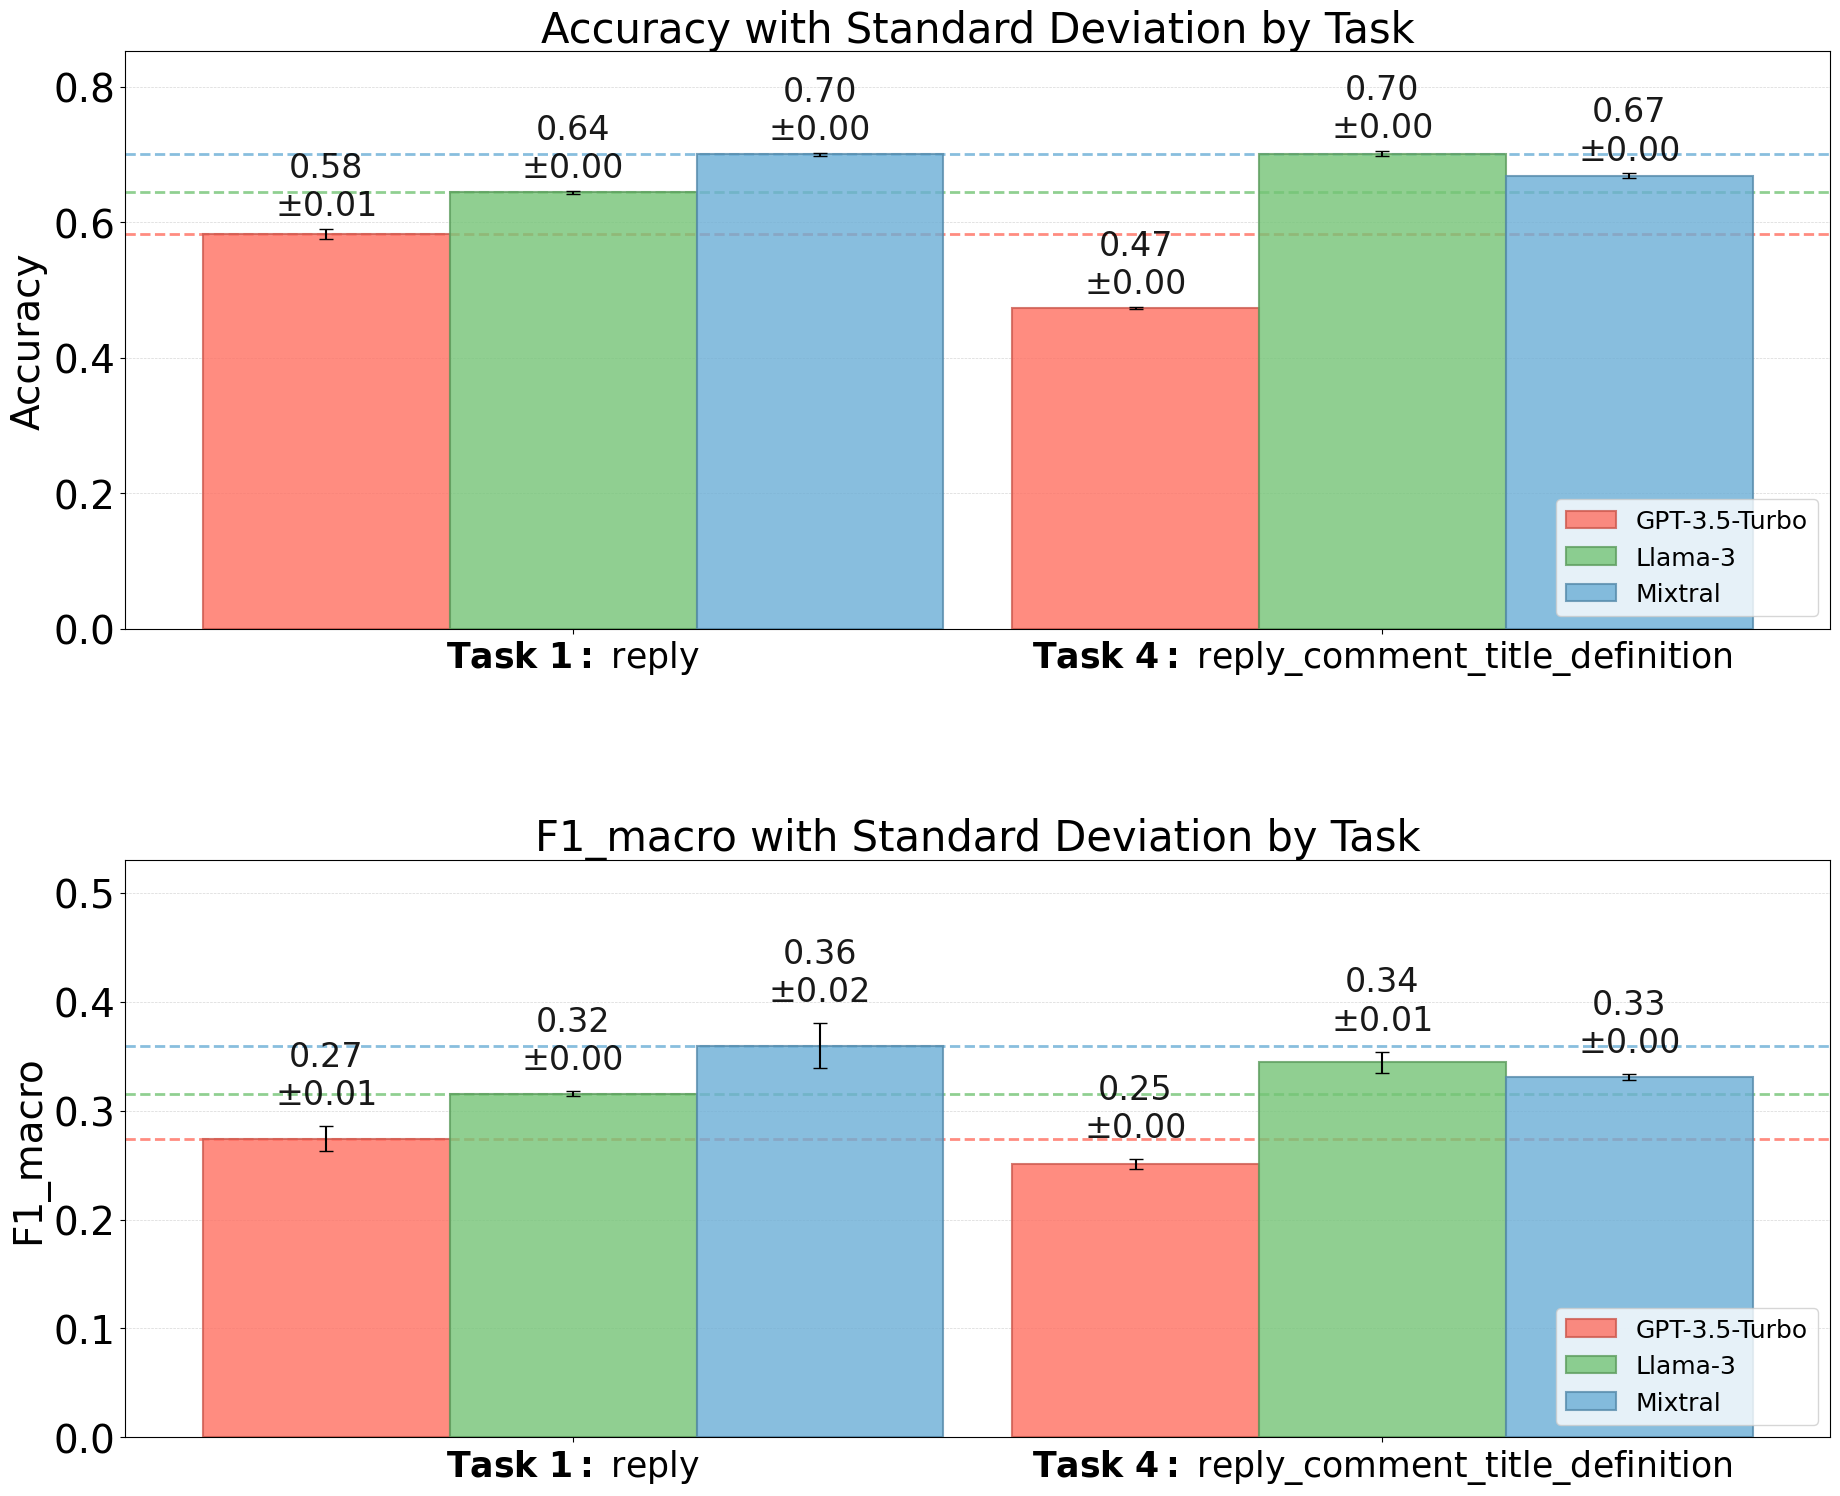

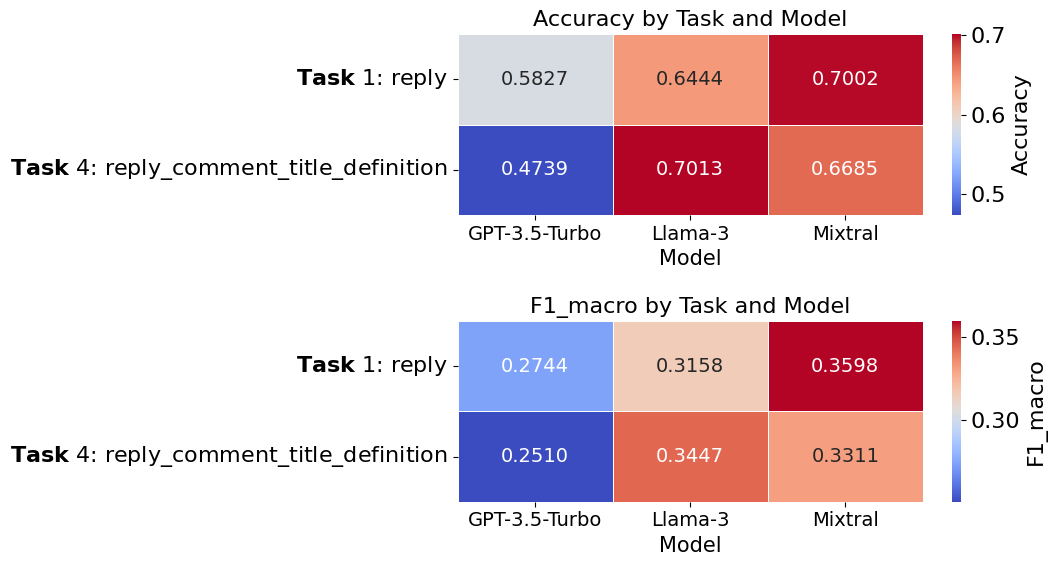

In [67]:
name_fig = f'Evaluation_Plots_comp/combined_metrics_barchart_by_task_and_model_with_GPT35T_BASELINE_1517.pdf'
name_fig_heatmap = f'Evaluation_Plots_comp/combined_metrics_heatmap_by_task_and_model_with_GPT35T_BASELINE_1517.pdf'
analyze_and_plot(metrics_df_with_gpt35t, summary_stats_with_gpt35t, name_fig)
analyze_and_plot_heatmap(metrics_df_with_gpt35t, summary_stats_with_gpt35t, name_fig_heatmap)

In [68]:
#summary_stats_with_gpt35t

In [146]:
metrics_df_with_gpt35t

,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,file_name,folder_path,task,...,f1_macro_std,precision_weighted_mean,precision_weighted_median,precision_weighted_std,recall_weighted_mean,recall_weighted_median,recall_weighted_std,f1_weighted_mean,f1_weighted_median,f1_weighted_std
0,0.741749,0.648527,0.516123,0.468919,0.804292,0.741749,0.710336,_EN_reply_classify_replies_1517_MIXTRAL_Hateba...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply,...,0.026038,0.814332,0.810812,0.008929,0.744059,0.744224,0.002434,0.709884,0.710159,0.002270
1,0.741749,0.657026,0.514831,0.466121,0.810812,0.741749,0.707634,_EN_reply_classify_replies_1517_MIXTRAL_Hateba...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply,...,0.026038,0.814332,0.810812,0.008929,0.744059,0.744224,0.002434,0.709884,0.710159,0.002270
2,0.747525,0.669791,0.518655,0.471916,0.821944,0.747525,0.713303,_EN_reply_classify_replies_1517_MIXTRAL_Hateba...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply,...,0.026038,0.814332,0.810812,0.008929,0.744059,0.744224,0.002434,0.709884,0.710159,0.002270
3,0.744224,0.533764,0.516285,0.411156,0.809240,0.744224,0.707989,_EN_reply_classify_replies_1517_MIXTRAL_Hateba...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply,...,0.026038,0.814332,0.810812,0.008929,0.744059,0.744224,0.002434,0.709884,0.710159,0.002270
4,0.745050,0.675141,0.517201,0.469810,0.825370,0.745050,0.710159,_EN_reply_classify_replies_1517_MIXTRAL_Hateba...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply,...,0.026038,0.814332,0.810812,0.008929,0.744059,0.744224,0.002434,0.709884,0.710159,0.002270
5,0.709571,0.401659,0.598046,0.422447,0.799769,0.709571,0.747456,_EN_reply_comment_title_definition_classify_re...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply_comment_title_definition,...,0.003574,0.798559,0.799301,0.001706,0.710396,0.709571,0.003781,0.747334,0.747456,0.002390
6,0.707096,0.406935,0.594652,0.429497,0.796608,0.707096,0.744886,_EN_reply_comment_title_definition_classify_re...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply_comment_title_definition,...,0.003574,0.798559,0.799301,0.001706,0.710396,0.709571,0.003781,0.747334,0.747456,0.002390
7,0.714521,0.401651,0.601601,0.424953,0.799301,0.714521,0.749661,_EN_reply_comment_title_definition_classify_re...,./log_files/MIXTRAL/csv_from_log_files/manuall...,reply_comment_title_definition,...,0.003574,0.798559,0.799301,0.001706,0.710396,0.709571,0.003781,0.747334,0.747456,0.002390
8,0.683168,0.496687,0.615146,0.405415,0.885854,0.683168,0.744023,_EN_reply_classify_replies_1517_LLAMA3_Hatebas...,./log_files/LLAMA3/csv_from_log_files/manually...,reply,...,0.003141,0.889024,0.885854,0.005999,0.684818,0.683993,0.002183,0.746266,0.745328,0.002831
9,0.687294,0.498676,0.586805,0.400292,0.895943,0.687294,0.749448,_EN_reply_classify_replies_1517_LLAMA3_Hatebas...,./log_files/LLAMA3/csv_from_log_files/manually...,reply,...,0.003141,0.889024,0.885854,0.005999,0.684818,0.683993,0.002183,0.746266,0.745328,0.002831
